Main IDEA: In highly volatile commodity markets where there is no obvious trend in the underlying asset, there are often stages of bullish or bearish trends, and it is difficult to predict the peak of each bullish period. However, in bearish trend, there can be overreactions in the market, which can present opportunities to profit by long position when the commodity price rebounds. Additionally, since the trend of selling in copper markets is stronger than buying, we can profit by shorting the underlying product during bear markets to generate additional income.

主要思想：在剧烈波动的商品市场中，标的产品不存在明显的趋势时，标的很容易出现阶段性的牛市或者熊市行情，我们很难预测每一次牛市的顶在哪里，但在熊市市场很容易出现过度反应，如果利用这一点，在商品价格反弹时进行做多就能获得收益。此外，由于铜市场中杀跌的趋势性比追涨更强，我们在熊市时做空标的以获得额外收入。

依照“华泰期货-CTA量化策略因子系列（一）：波动率因子”中的定义，对三种市场情绪的定义如下

Bullish Sentiment Recognition:
$$ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)-Price.std(long\_ term).std(long\_ term)  \  \ 
and \ \  Price>Price.shift(90) $$
Bearish Sentiment Recognition:
$$ Price.std(long\_ term)>Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90) $$
Overreacted Sentiment Recognition:
$$ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90) $$

在我们的策略当中，我们生成信号来控制多空。做多信号来源于过度反应后的反弹，做空信号来自对暴跌趋势的跟随。
做多信号的具体定义：

1.市场过度反应周期（sentiment_overreact），波动率下降，且价格低于长期以前

2.高于短期和中期内价格，但低于长期前的价格（此部分逻辑被包含在第一点当中），说明短期内价格在修复，但长期来看低于过去的内在价值

3.宏观辅助指标，共五个，中国铜库存，COMEX铜库存，LME亚洲铜库存，中国铜产量，中国铜进口量，当这些指标下降时供给减少价格涨高。但由于其统计的频率口径存在差别，我们粗略地将有两个及以上的标的满足不上升（长期来看应当增长，所以持平也视为积极）条件视为做多信号。库存下降不一定会导致价格上升，但所有库存都不下降肯定不是价格上升的积极信号。

做空信号的具体定义：

1.市场处于熊市周期（sentiment bearish），波动率上升，价格低于长期以前

2.短期和中期内处于下降

3.并非处于反转或者震荡区间

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

long_term=20
mid_term=10
short_term=5

data=pd.read_csv("CU0.SHF.csv", index_col=0).drop(columns=['Contract'])
external_data=pd.read_csv('modified_external_data.csv',encoding='utf-8',sep=',')
data.reset_index(inplace=True)
data=data.rename(columns={'index':'date','Open_adj':'open','High_adj':'high','Low_adj':'low','Close_adj':'close','Volume':'volume'})
data=data.drop(columns=['open','high','low','volume','Open_interest'])
data=pd.merge(data,external_data,on='date',how='left')

data['short_up']=(data['close']>data['close'].rolling(short_term).mean()).astype(int)
data['short_down']=(data['close']<data['close'].rolling(short_term).mean()).astype(int)
data['downward_inverse']=(data['close']>data['close'].rolling(mid_term).min()).astype(int)
data['mid_up']=(data['close']>data['close'].rolling(mid_term).mean()).astype(int)
data['mid_down']=(data['close']<data['close'].rolling(mid_term).mean()).astype(int)
data['vol_short']=data['close'].rolling(short_term).std()
data['vol_long']=data['close'].rolling(long_term).std()
data['vol_long_mean']=data['vol_long'].rolling(long_term).mean()
data['vol_long_std']=data['vol_long'].rolling(long_term).std()

data['sentiment_bullish']=(data['vol_long']<data['vol_long_mean']-data['vol_long_std'])*(data['close']>data['close'].shift(90)).astype(int)
data['sentiment_bearish']=(data['vol_long']>data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)
data['sentiment_overreact']=(data['vol_long']<data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)

data['spot_inventory_CN']=data['spot_inventory_CN']>0
data['inventory_COMEX']=data['inventory_COMEX']>0
data['inventory_LME_asia']=data['inventory_LME_asia']>0
data['production_CN']=data['production_CN']>0
data['import_refined_CN']=data['import_refined_CN']>0

# fundamental_data=data_fetch.collect_data()
# data=pd.merge(data,fundamental_data,on='date',how='left')
data['long_signal']=data['sentiment_overreact']*data['short_up']*data['mid_up']*\
    (((1-data['spot_inventory_CN'])+(1-data['inventory_COMEX'])+(1-data['inventory_LME_asia'])   \
        +(1-data['production_CN'])+(1-data['import_refined_CN']))>1)
    
data['short_signal']=data['sentiment_bearish']*data['short_down']*data['mid_down']*(1-data['downward_inverse'])

data=data[['date','close','long_signal','short_signal','vol_short','vol_long']]

关于回测的设定：保证金比率0.2，手续费0.02%，本金10,000,000
我们将生成的信号向后移动一天，昨天的量价信息作为今天的调仓标准，今天的仓位来决定明天的保证金余额（为了简便，将今日调仓所花的手续费记在明日保证金内，不影响最后结果）
对于能够使用的保证金的比例，我们采用了sigmoid函数，输入的x为短期波动率与长期波动率的比，由于我们的策略基于高波动率，当且仅当比值足够大时我们才进行投资

In [79]:

#todya's signal is based on yesterday's data,and margin at the end of tommorw is only based on today's signal
data[['long_signal','short_signal','vol_short','vol_long']]=data[['long_signal','short_signal','vol_short','vol_long']].shift(1)
data['position']=0
data['margin']=10000000
margin_ratio=0.2
commission=0.0002
data=data.dropna()
data=data.reset_index(drop=True)
#avoid SettingWithCopyWarning
for i in range(1,data.shape[0]-1):
    invest_ratio=1/(1+np.exp(-data['vol_short'].iloc[i]/data['vol_long'].iloc[i]))
    if invest_ratio<0.6:
        position=0
        data.loc[i+1,'margin']=data['margin'].iloc[i]
    else:
        if data['long_signal'].iloc[i]==1:
            position=int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        elif data['short_signal'].iloc[i]==1:
            position=-int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        else:
            position=0
            data.loc[i+1,'margin']=data['margin'].iloc[i]
            
    data.loc[i,'position']=position
    
data

,date,close,long_signal,short_signal,vol_short,vol_long,position,margin
0,1/2/2010,54397.64725,0.0,0.0,1867.916877,1551.092400,0,1.000000e+07
1,2/2/2010,54297.61480,0.0,0.0,2305.922683,2028.624279,0,1.000000e+07
2,3/2/2010,55887.54496,0.0,0.0,2258.124863,2385.668508,0,1.000000e+07
3,4/2/2010,53997.62798,0.0,0.0,1304.631124,2477.777242,0,1.000000e+07
4,5/2/2010,51977.71671,0.0,0.0,815.561216,2709.777066,0,1.000000e+07
...,...,...,...,...,...,...,...,...
3164,14/2/2023,79736.15872,0.0,0.0,256.521580,972.867481,0,1.012774e+08
3165,15/2/2023,79689.71948,0.0,0.0,259.810790,784.969563,0,1.012774e+08
3166,16/2/2023,79538.79199,0.0,0.0,259.810790,751.552594,0,1.012774e+08
3167,17/2/2023,79968.35487,0.0,0.0,245.596144,757.286544,0,1.012774e+08


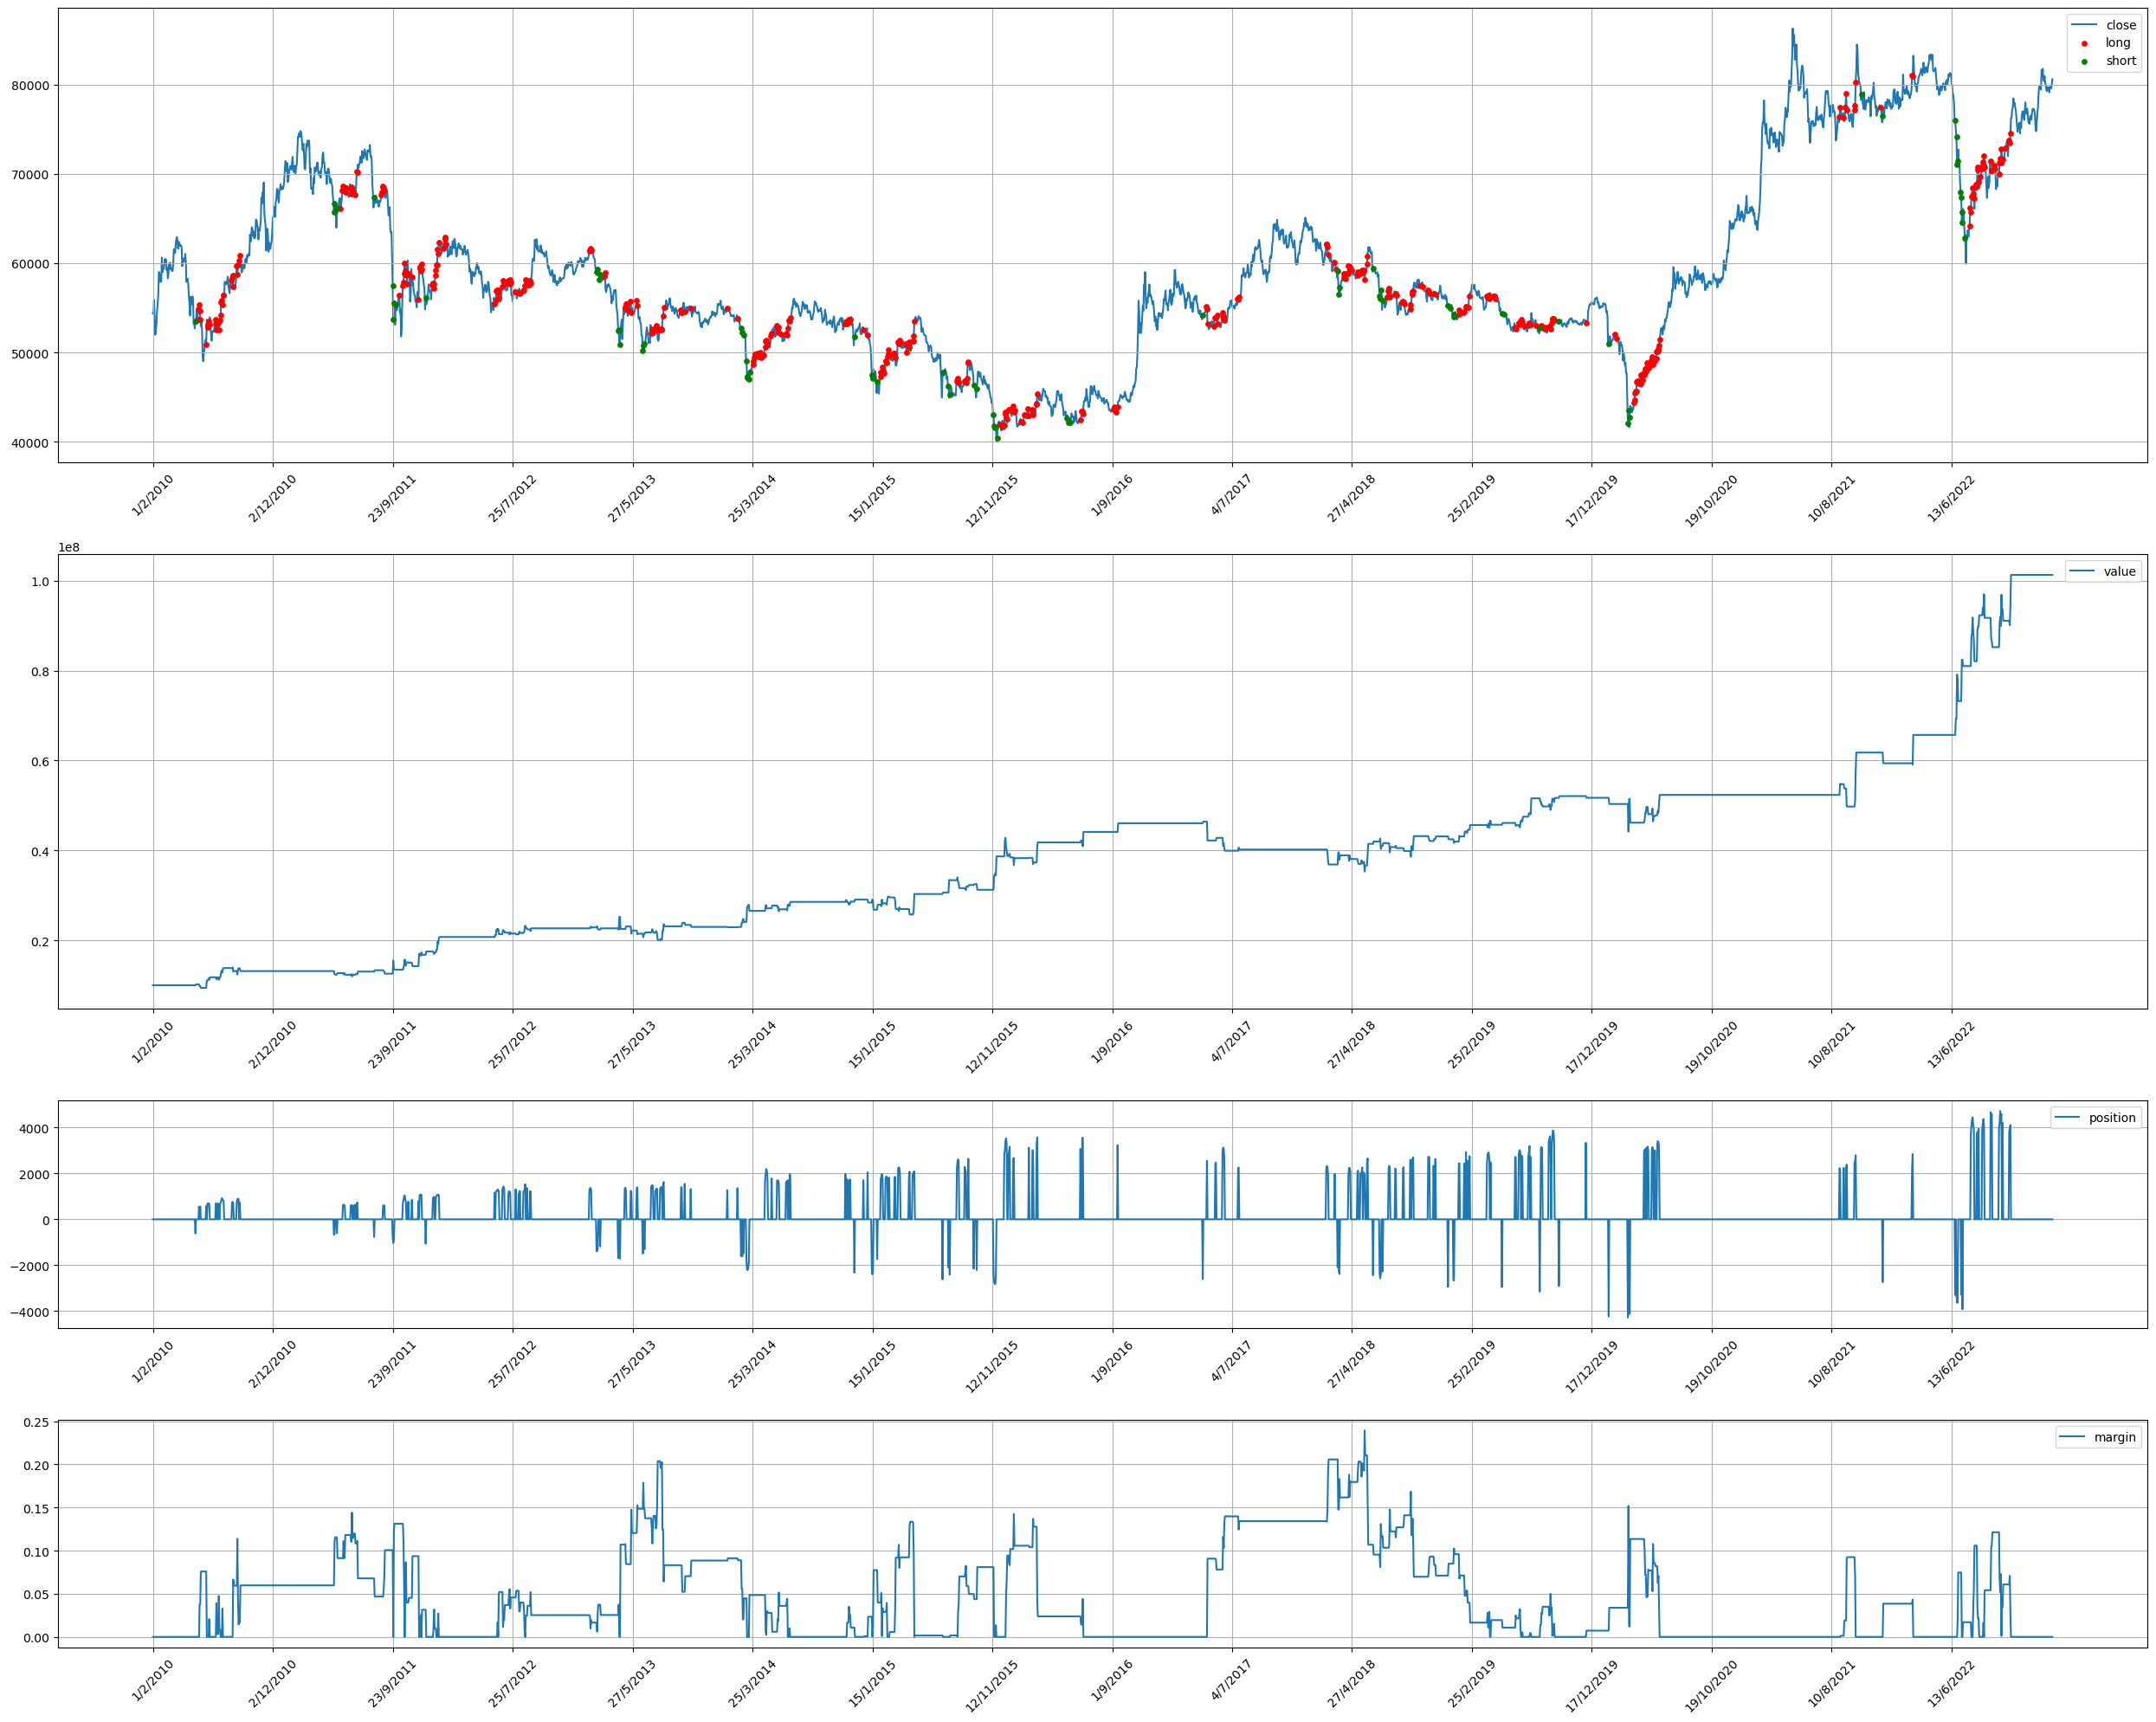

In [93]:
long_date=data[(data['long_signal']==1)]
short_date=data[(data['short_signal']==1)]
fig,ax=plt.subplots(4,1,figsize=(25,20),dpi=100,gridspec_kw={'height_ratios':[2,2,1,1]})
ax[0].plot(data['date'],data['close'],label='close',zorder=1)
ax[0].grid()
ax[0].set_xticks(data['date'][::200])
ax[0].set_xticklabels(data['date'][::200],rotation=45)
ax[0].scatter(long_date['date'],long_date['close'],label='long',s=15,color='red',zorder=2)
ax[0].scatter(short_date['date'],short_date['close'],label='short',s=15,color='green',zorder=3)
ax[0].legend()
ax[0].set_title('close price')
ax[1].grid()
ax[1].plot(data['date'],data['margin'],label='value')
ax[1].set_xticks(data['date'][::200])
ax[1].set_xticklabels(data['date'][::200],rotation=45)
ax[1].legend()
ax[1].set_title('margin')
ax[2].grid()
ax[2].plot(data['date'],data['position'],label='position')
ax[2].set_xticks(data['date'][::200])
ax[2].set_xticklabels(data['date'][::200],rotation=45)
ax[2].legend()
ax[2].set_title('position')
ax[3].grid()
ax[3].plot(data['date'],(np.maximum.accumulate(data['margin'])-data['margin'])/np.maximum.accumulate(data['margin']),label='drawdown')
ax[3].set_xticks(data['date'][::200])
ax[3].set_xticklabels(data['date'][::200],rotation=45)
ax[3].legend()
ax[3].set_title('drawdown')
plt.tight_layout()
plt.show()

In [104]:
print("annual return:\t",(data['margin'].iloc[-1]/data['margin'].iloc[0])**(1/12)-1)
print("max drawdown:\t",np.max((np.maximum.accumulate(data['margin'])-data['margin'])/np.maximum.accumulate(data['margin'])))
print("winning rate:\t",np.sum(data['margin'].iloc[1:].values>data['margin'].iloc[:-1])/np.sum(data['margin'].iloc[1:].values!=data['margin'].iloc[:-1]))

annual return:	 0.21280988642606746
max drawdown:	 0.23941902054693487
winning rate:	 0.5297157622739018
